## Regression: Boston Housing Data
https://archive.ics.uci.edu/ml/machine-learning-databases/housing/

** Dataset Information: **

506 Boston housing information including value of houses

** Attribute Information: (13 features and 1 class)**

1. CRIM      per capita crime rate by town
2. ZN        proportion of residential land zoned for lots over 25,000 sq.ft.
                 
3. INDUS     proportion of non-retail business acres per town
4. CHAS      Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
                 
5. NOX       nitric oxides concentration (parts per 10 million)
6. RM        average number of rooms per dwelling
7. AGE       proportion of owner-occupied units built prior to 1940
8. DIS       weighted distances to five Boston employment centres
9. RAD       index of accessibility to radial highways
10. TAX      full-value property-tax rate per $10,000
11. PTRATIO  pupil-teacher ratio by town
12. B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
                 
13. LSTAT    % lower status of the population
14. MEDV     Median value of owner-occupied homes in $1000's

** Objective of this project **

predict value of house (MEDV) based on the other features

## Data

In [1]:
import findspark
findspark.init('/home/danny/spark-2.2.1-bin-hadoop2.7')

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('boston_housing').getOrCreate()

In [2]:
# Load Data
df = spark.read.csv('boston_housing.csv',inferSchema=True,header=True)
# Inspect Data
df.printSchema()

root
 |-- CRIM: double (nullable = true)
 |-- ZN: double (nullable = true)
 |-- INDUS: double (nullable = true)
 |-- CHAS: integer (nullable = true)
 |-- NOX: double (nullable = true)
 |-- RM: double (nullable = true)
 |-- AGE: double (nullable = true)
 |-- DIS: double (nullable = true)
 |-- RAD: integer (nullable = true)
 |-- TAX: integer (nullable = true)
 |-- PTRATIO: double (nullable = true)
 |-- B: double (nullable = true)
 |-- LSTAT: double (nullable = true)
 |-- MEDV: double (nullable = true)



In [3]:
df = df.withColumnRenamed('MEDV','label') #class -> label
df.show(5)

+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+-----+
|   CRIM|  ZN|INDUS|CHAS|  NOX|   RM| AGE|   DIS|RAD|TAX|PTRATIO|     B|LSTAT|label|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+-----+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 396.9| 4.98| 24.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 396.9| 9.14| 21.6|
|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8|392.83| 4.03| 34.7|
|0.03237| 0.0| 2.18|   0|0.458|6.998|45.8|6.0622|  3|222|   18.7|394.63| 2.94| 33.4|
|0.06905| 0.0| 2.18|   0|0.458|7.147|54.2|6.0622|  3|222|   18.7| 396.9| 5.33| 36.2|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+-----+
only showing top 5 rows



In [4]:
df.head()

Row(CRIM=0.00632, ZN=18.0, INDUS=2.31, CHAS=0, NOX=0.538, RM=6.575, AGE=65.2, DIS=4.09, RAD=1, TAX=296, PTRATIO=15.3, B=396.9, LSTAT=4.98, label=24.0)

## Data preprocessing

In [5]:
# Combine features into a single column vector
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=df.columns[:-1],outputCol='features')                            
final_data = assembler.transform(df).select('features','label')
final_data.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.00632,18.0,2.3...| 24.0|
|[0.02731,0.0,7.07...| 21.6|
|[0.02729,0.0,7.07...| 34.7|
|[0.03237,0.0,2.18...| 33.4|
|[0.06905,0.0,2.18...| 36.2|
+--------------------+-----+
only showing top 5 rows



In [6]:
# Split Train Test sets
seed = 101
train_data,test_data = final_data.randomSplit([0.7,0.3],seed=seed)
train_data.describe().show()
test_data.describe().show()

+-------+------------------+
|summary|             label|
+-------+------------------+
|  count|               372|
|   mean|22.347580645161297|
| stddev| 9.073222327441464|
|    min|               5.0|
|    max|              50.0|
+-------+------------------+

+-------+------------------+
|summary|             label|
+-------+------------------+
|  count|               134|
|   mean|23.047014925373137|
| stddev| 9.548504510694489|
|    min|               5.0|
|    max|              50.0|
+-------+------------------+



## Baseline Model

In [7]:
from pyspark.ml.regression import (LinearRegression,GBTRegressor,                                   
                                   DecisionTreeRegressor,RandomForestRegressor)                                   
from pyspark.ml.evaluation import RegressionEvaluator

#### Train Models

In [8]:
# Initialize multiple regressors
lrr = LinearRegression()
dtr = DecisionTreeRegressor(seed=seed)
rfr = RandomForestRegressor(seed=seed)
gbr = GBTRegressor(seed=seed)

# Train the models 
lr_model = lrr.fit(train_data)
dtr_model = dtr.fit(train_data)
rfr_model = rfr.fit(train_data)
gbr_model = gbr.fit(train_data)

#### Evaluate Models

In [9]:
# Make predictions
lr_predictions = lr_model.transform(test_data)
dtr_predictions = dtr_model.transform(test_data)
rfr_predictions = rfr_model.transform(test_data)
gbr_predictions = gbr_model.transform(test_data)

# Evaluate the models
mse_eval = RegressionEvaluator(metricName='mse')
r2_eval = RegressionEvaluator(metricName='r2')
print('\t\t\tMSE\tR2')
print('Linear Regression:\t{:.3f}\t{:.3f}'.format(mse_eval.evaluate(lr_predictions),
                                          r2_eval.evaluate(lr_predictions)))
print('Decision Tree:\t\t{:.3f}\t{:.3f}'.format(mse_eval.evaluate(dtr_predictions),
                                          r2_eval.evaluate(dtr_predictions)))
print('Random Forest:\t\t{:.3f}\t{:.3f}'.format(mse_eval.evaluate(rfr_predictions),
                                          r2_eval.evaluate(rfr_predictions)))
print('GBT:\t\t\t{:.3f}\t{:.3f}'.format(mse_eval.evaluate(gbr_predictions),
                                          r2_eval.evaluate(gbr_predictions)))

			MSE	R2
Linear Regression:	32.735	0.638
Decision Tree:		55.840	0.383
Random Forest:		22.824	0.748
GBT:			52.562	0.419


## Parameter tuning

#### Grid Search

In [10]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# randomforest
regressor = RandomForestRegressor(seed=seed)
# grid params
paramGrid = ParamGridBuilder() \
    .addGrid(regressor.numTrees, [20,50,100]) \
    .addGrid(regressor.maxDepth, [5,10]) \
    .build()
# cross validation
crossval = CrossValidator(estimator=regressor,
                          estimatorParamMaps=paramGrid,
                          evaluator=mse_eval,
                          numFolds=3, 
                          seed=seed)
cvModel = crossval.fit(train_data)
# results
print(cvModel.avgMetrics)
print(cvModel.bestModel) #numTrees=50, maxDepth=10

[13.719501143300205, 12.793663094493308, 13.701430927963987, 12.442737353680325, 13.822752468610089, 12.883399324015599]
RandomForestRegressionModel (uid=RandomForestRegressor_4f8096340763d9230e90) with 50 trees


#### Evaluate the best model

In [11]:
# make predictions
predictions = cvModel.transform(test_data)
# calculate mse, r2 score
print('\t\t\tMSE\tR2')
print('Linear Regression:\t{:.3f}\t{:.3f}'.format(mse_eval.evaluate(predictions),
                                          r2_eval.evaluate(predictions)))

			MSE	R2
Linear Regression:	20.930	0.769


## Final Model

In [12]:
# Train the model
regressor = RandomForestRegressor(numTrees=50,maxDepth=10,seed=seed)                                  
final_model = regressor.fit(train_data)
# Make predictions
predictions = final_model.transform(test_data)
predictions.show(5)
# Evaluate the model
rmse_eval = RegressionEvaluator(metricName='rmse')
print('RMSE:\t{:.3f}'.format(rmse_eval.evaluate(predictions)))
print('MSE:\t{:.3f}'.format(mse_eval.evaluate(predictions)))
print('R2:\t{:.3f}'.format(r2_eval.evaluate(predictions)))

+--------------------+-----+------------------+
|            features|label|        prediction|
+--------------------+-----+------------------+
|[0.01381,80.0,0.4...| 50.0| 45.66733333333334|
|[0.01439,60.0,2.9...| 29.1| 30.79745320910972|
|[0.01501,80.0,2.0...| 24.5| 27.67018024958109|
|[0.01709,90.0,2.0...| 30.1| 32.54419523809523|
|[0.01965,80.0,1.7...| 20.1|23.059304761904762|
+--------------------+-----+------------------+
only showing top 5 rows

RMSE:	4.575
MSE:	20.930
R2:	0.769


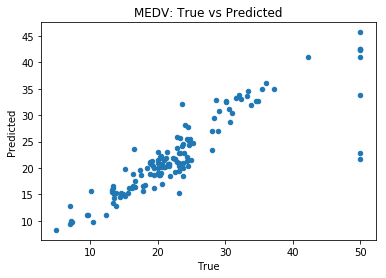

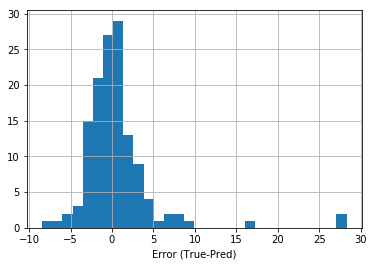

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# visualize the results
df_pred = predictions.toPandas()
df_pred.plot.scatter(x='label',y='prediction')
plt.title('MEDV: True vs Predicted')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()
# residuals
df_res = df_pred['label']-df_pred['prediction']
df_res.hist(bins=30)
plt.xlabel('Error (True-Pred)')
plt.show()

In [14]:
spark.stop()